In [40]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-07-01T14:53:40.892663-04:00

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

Compiler    : MSC v.1937 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 167 Stepping 1, GenuineIntel
CPU cores   : 16
Architecture: 64bit



### Importing the libraries

In [67]:
## bibliotecas
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import random

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, cut_tree, linkage, fcluster
import scipy.cluster.hierarchy as sch


pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_style('ticks')

warnings.filterwarnings('ignore')


%matplotlib inline
%watermark -w
%watermark -iv

Watermark: 2.4.3

scipy     : 1.12.0
matplotlib: 3.8.3
seaborn   : 0.13.2
pandas    : 2.2.1
numpy     : 1.26.4



In [42]:
random.seed(1234)

In [43]:
# Support Functions

def evaluate_clustering(X, k_values, random_state=0):
    silhouette_scores = {
        'kmeans': [],
        'agg': [],
        'gmm': []
    }
    
    for k in k_values:
        # KMeans
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels_kmeans = kmeans.fit_predict(X)
        silhouette_scores['kmeans'].append(silhouette_score(X, labels_kmeans))
        
        # Agglomerative Clustering
        agg = AgglomerativeClustering(n_clusters=k)
        labels_agg = agg.fit_predict(X)
        silhouette_scores['agg'].append(silhouette_score(X, labels_agg))
        
        # Gaussian Mixture Model
        gmm = GaussianMixture(n_components=k, random_state=random_state)
        labels_gmm = gmm.fit_predict(X)
        silhouette_scores['gmm'].append(silhouette_score(X, labels_gmm))
    
    return silhouette_scores

def plot_silhouette_scores(k_values, silhouette_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouette_scores['kmeans'], label='KMeans', marker='o')
    plt.plot(k_values, silhouette_scores['agg'], label='Agglomerative Clustering', marker='o')
    plt.plot(k_values, silhouette_scores['gmm'], label='Gaussian Mixture', marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Different Clustering Algorithms')
    plt.legend()
    plt.grid(True)
    plt.show()



### Importing the data

In [44]:
# Data

data = pd.read_csv('D:/OneDrive/PROJETOS_R_GIT/2024/RFV_PYTHON/DADOS/df_final_rfv.csv', encoding='latin')

In [45]:
data.head()

,Unnamed: 0,id_client,amount,total_purchase,recency
0,0,00006A95660,1,0.000,1339
1,1,000226822A0,1,0.000,1021
2,2,00026208A2A,1,39980.000,923
3,3,00032b5965b,1,4122.500,246
4,4,00035Ab4AA0,1,0.000,1329


In [46]:
data_tmp = data[['id_client', 'amount', 'total_purchase', 'recency']].copy()

### Preprocessing

In [47]:
# Scaling 

scaler = StandardScaler()

# columns to be scaled
columns_to_scale = ['amount', 'total_purchase', 'recency']

# Fit and transform the selected columns
data_tmp_scaled = scaler.fit_transform(data_tmp[columns_to_scale])

# Convert the scaled data back to a DataFrame
data_tmp_scaled = pd.DataFrame(data_tmp_scaled, columns=columns_to_scale)

In [48]:
data_tmp_scaled

,amount,total_purchase,recency
0,-0.337,-0.590,0.543
1,-0.337,-0.590,0.054
2,-0.337,1.815,-0.096
3,-0.337,-0.342,-1.135
4,-0.337,-0.590,0.527
...,...,...,...
35295,-0.337,1.252,1.633
35296,-0.337,-0.590,-0.624
35297,-0.337,-0.590,1.388
35298,-0.337,0.547,1.066


# 1. Clustering

I intend to compare different clustering algorithms (KMeans, Hierarchical and Gaussian Mixtures Model). For each one, I will use the silhoutte score to select an optimal *k* value.

This metric measures how similar each data point in one clusters is to the other points within the same cluster (a) compared to the most similar neighboring cluster (b).

$Silhouette\_Score = \frac{(b-a)}{max(a,b)}$

Where:

- *a* is the average distance between a point and all other points in the same cluster.
- *b* is the average distance between a point and all points in the nearest cluster.

The silhoutte score ranges from -1 to +1 and higher values indicate better-defined and well-separated clusters.

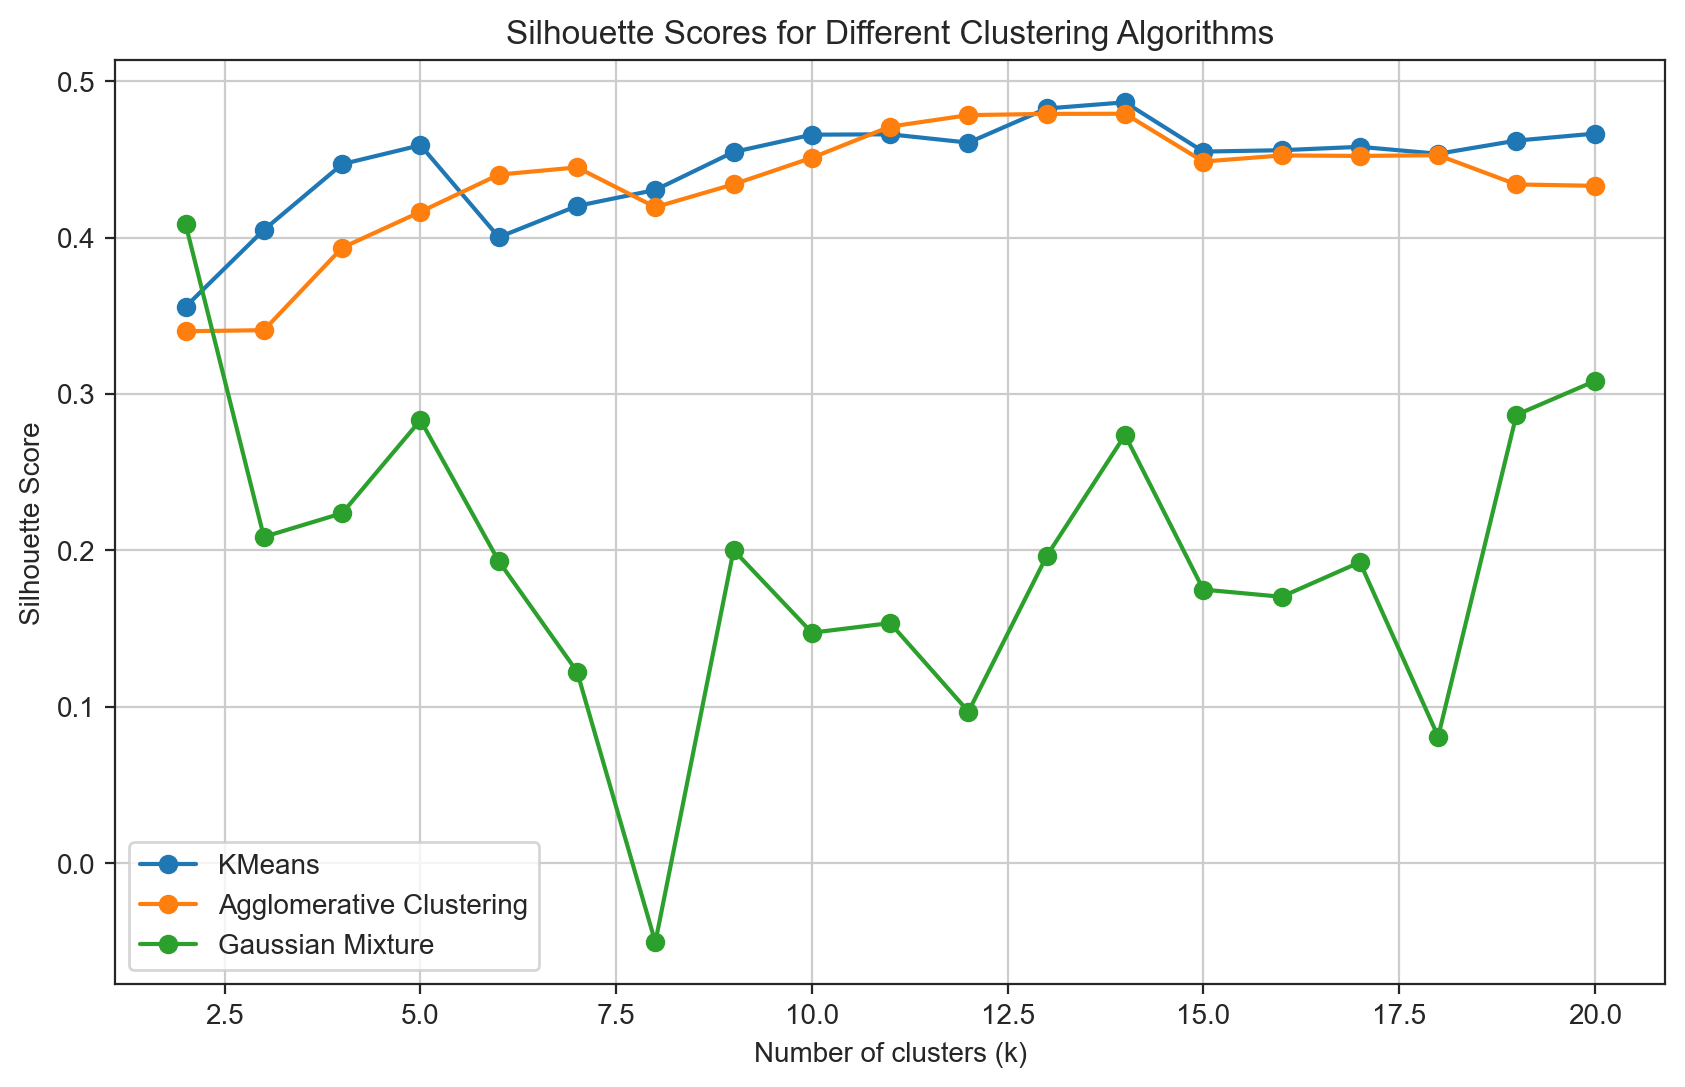

In [49]:
# Define range of k values
k_values = range(2, 21)

# Evaluate clustering
silhouette_scores = evaluate_clustering(data_tmp_scaled, k_values)

# Plot the silhouette scores
plot_silhouette_scores(k_values, silhouette_scores)

Considering the silhoutte scores:
1. KMeans (Blue Line):
    - The silhoutte score generally increases with the number of clusters, peaking around k = 12 and stabilizing afterward.
    - KMeans performs well with higher values of k.
  
2. Agglomerative Clustering (Orange Line):
    - Similar to KMeans, the silhoutte score increases and stabilizes around k=12.
    - The silhoutte score is consistently, suggesting good clustering performance.

  
3. Gaussian Mixture (Green Line):
   - Shows more variability and generally lower silhoutte scores compared to KMeans and Agglomerative Clustering.
    - Indicates less consistent clustering performance across different k values.

Conclusion:
- **KMeans and Agglomerative Clustering**: optimal number of cluster is around 12.
- **Gaussian Mixture**: shows inconsistent performance and may not be ideal for this dataset.

Considering these results, I will just follow with **KMeans and Agglomerative Clustering**.

## 1.1. KMeans

In [50]:
wcss = list()


for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, random_state=1234)
    kmeans.fit(data_tmp_scaled)
    wcss.append(kmeans.inertia_)

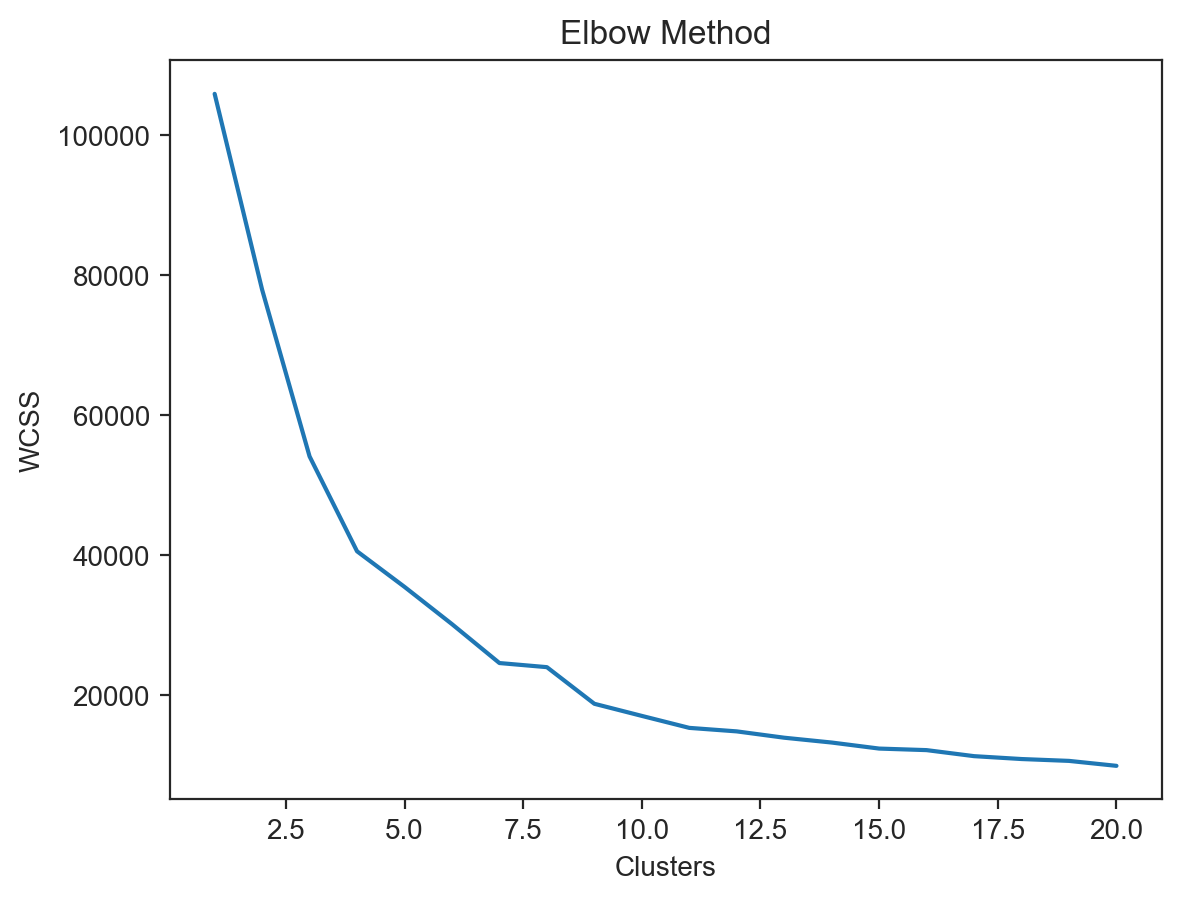

In [51]:
plt.plot(range(1,21), wcss)
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show()

- Optimal Number of Clusters: Based on the Elbow Method, the optimal number of clusters appears to be around 4 to 6. This range provides a good balance between minimizing WCSS and avoiding overfitting with too many clusters.

- I tried a few numbers of *k* to see how the clustering works, but for some business purposes, I will just show the KMeans using k = 9.

- Considering the Elbow Method, the Silhoutte score and the business strategy (there are some factors that limit the number of clusters), we decide to use 9 clusters.

In [52]:
# Model with 9 clusters

kmeans = KMeans(n_clusters=9)
kmeans.fit(data_tmp_scaled)

data_tmp['CLUSTER'] = kmeans.labels_

data_tmp

,id_client,amount,total_purchase,recency,CLUSTER
0,00006A95660,1,0.000,1339,0
1,000226822A0,1,0.000,1021,0
2,00026208A2A,1,39980.000,923,5
3,00032b5965b,1,4122.500,246,2
4,00035Ab4AA0,1,0.000,1329,0
...,...,...,...,...,...
35295,bbb95b9654,1,30620.000,2049,3
35296,bbbb0420Ab2,1,0.000,579,2
35297,bbbb3349649,1,0.000,1890,6
35298,bbbb422A9b2,1,18900.000,1680,3


In [53]:
data_tmp['CLUSTER'].value_counts()

CLUSTER
6    8657
2    8614
0    6814
5    3921
3    3415
1    2758
7     539
4     482
8     100
Name: count, dtype: int64

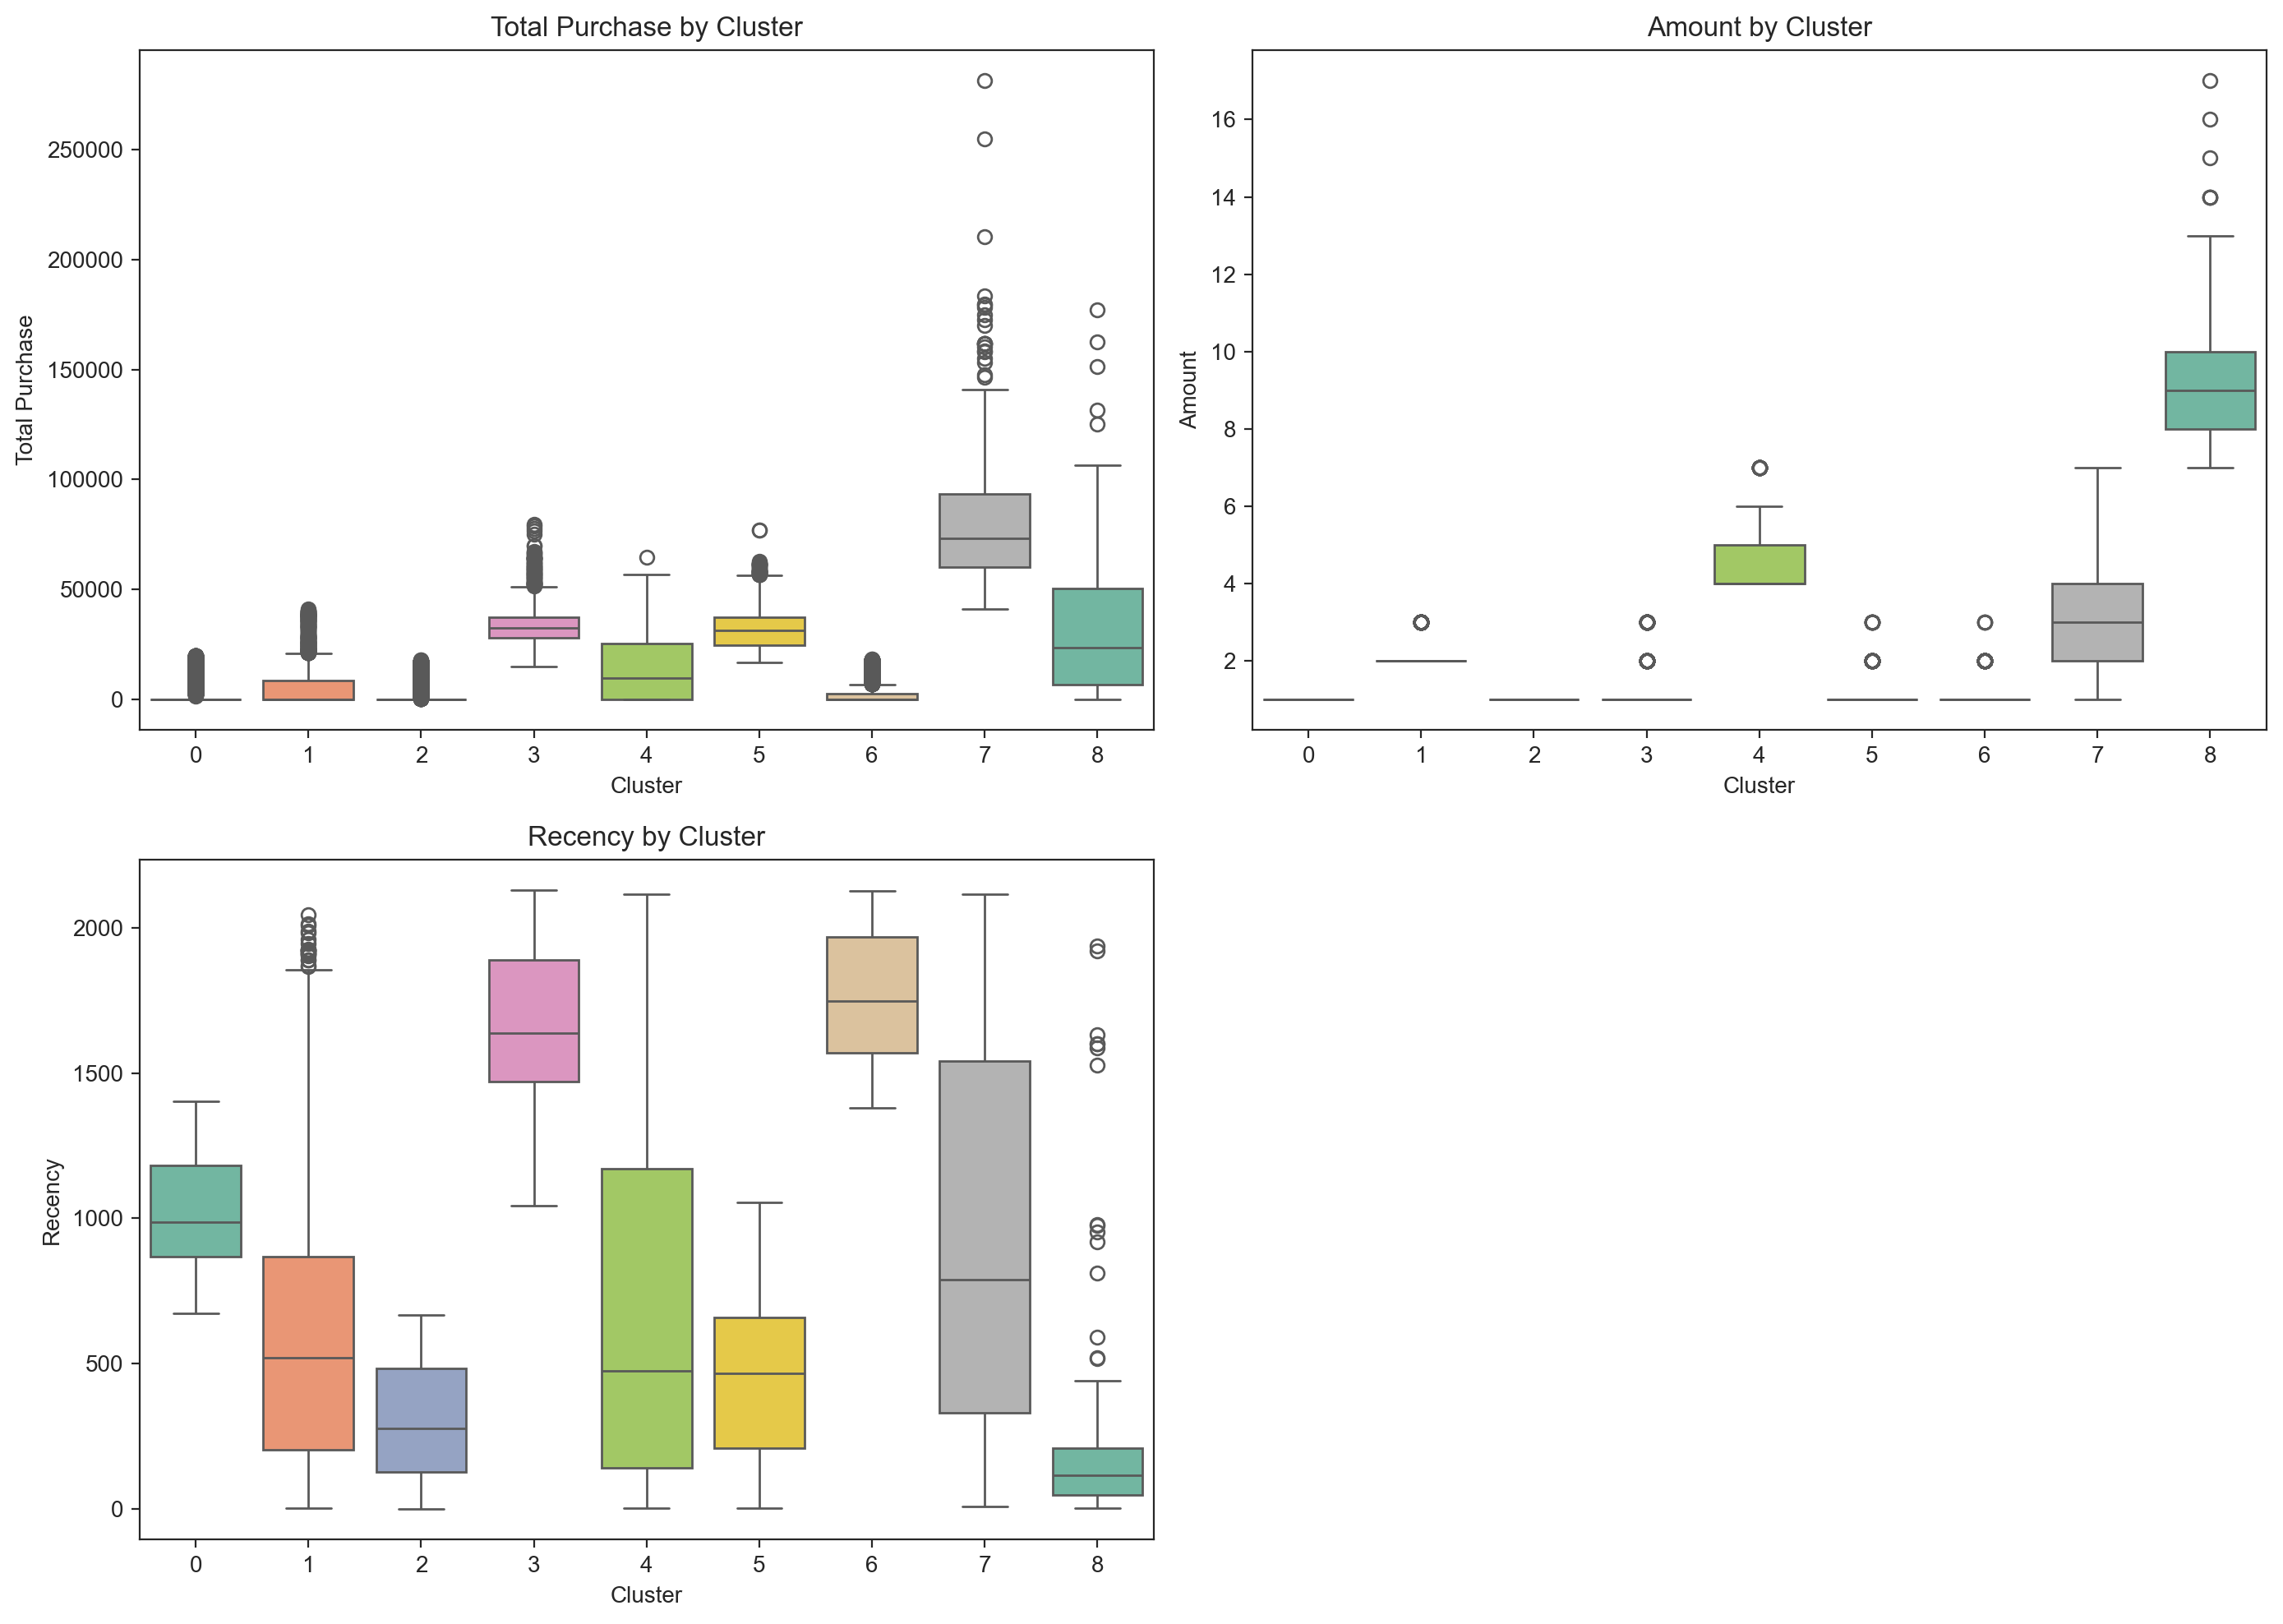

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(y = 'total_purchase', x = 'CLUSTER', data = data_tmp,  ax=axes[0, 0], palette='Set2')
axes[0, 0].set_title('Total Purchase by Cluster')
axes[0, 0].set_ylabel('Total Purchase')
axes[0, 0].set_xlabel('Cluster')

sns.boxplot(y = 'amount', x = 'CLUSTER', data = data_tmp,  ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('Amount by Cluster')
axes[0, 1].set_ylabel('Amount')
axes[0, 1].set_xlabel('Cluster')

sns.boxplot(y = 'recency', x = 'CLUSTER', data = data_tmp, ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('Recency by Cluster')
axes[1, 0].set_ylabel('Recency')
axes[1, 0].set_xlabel('Cluster')

axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


<Axes: xlabel='total_purchase', ylabel='amount'>

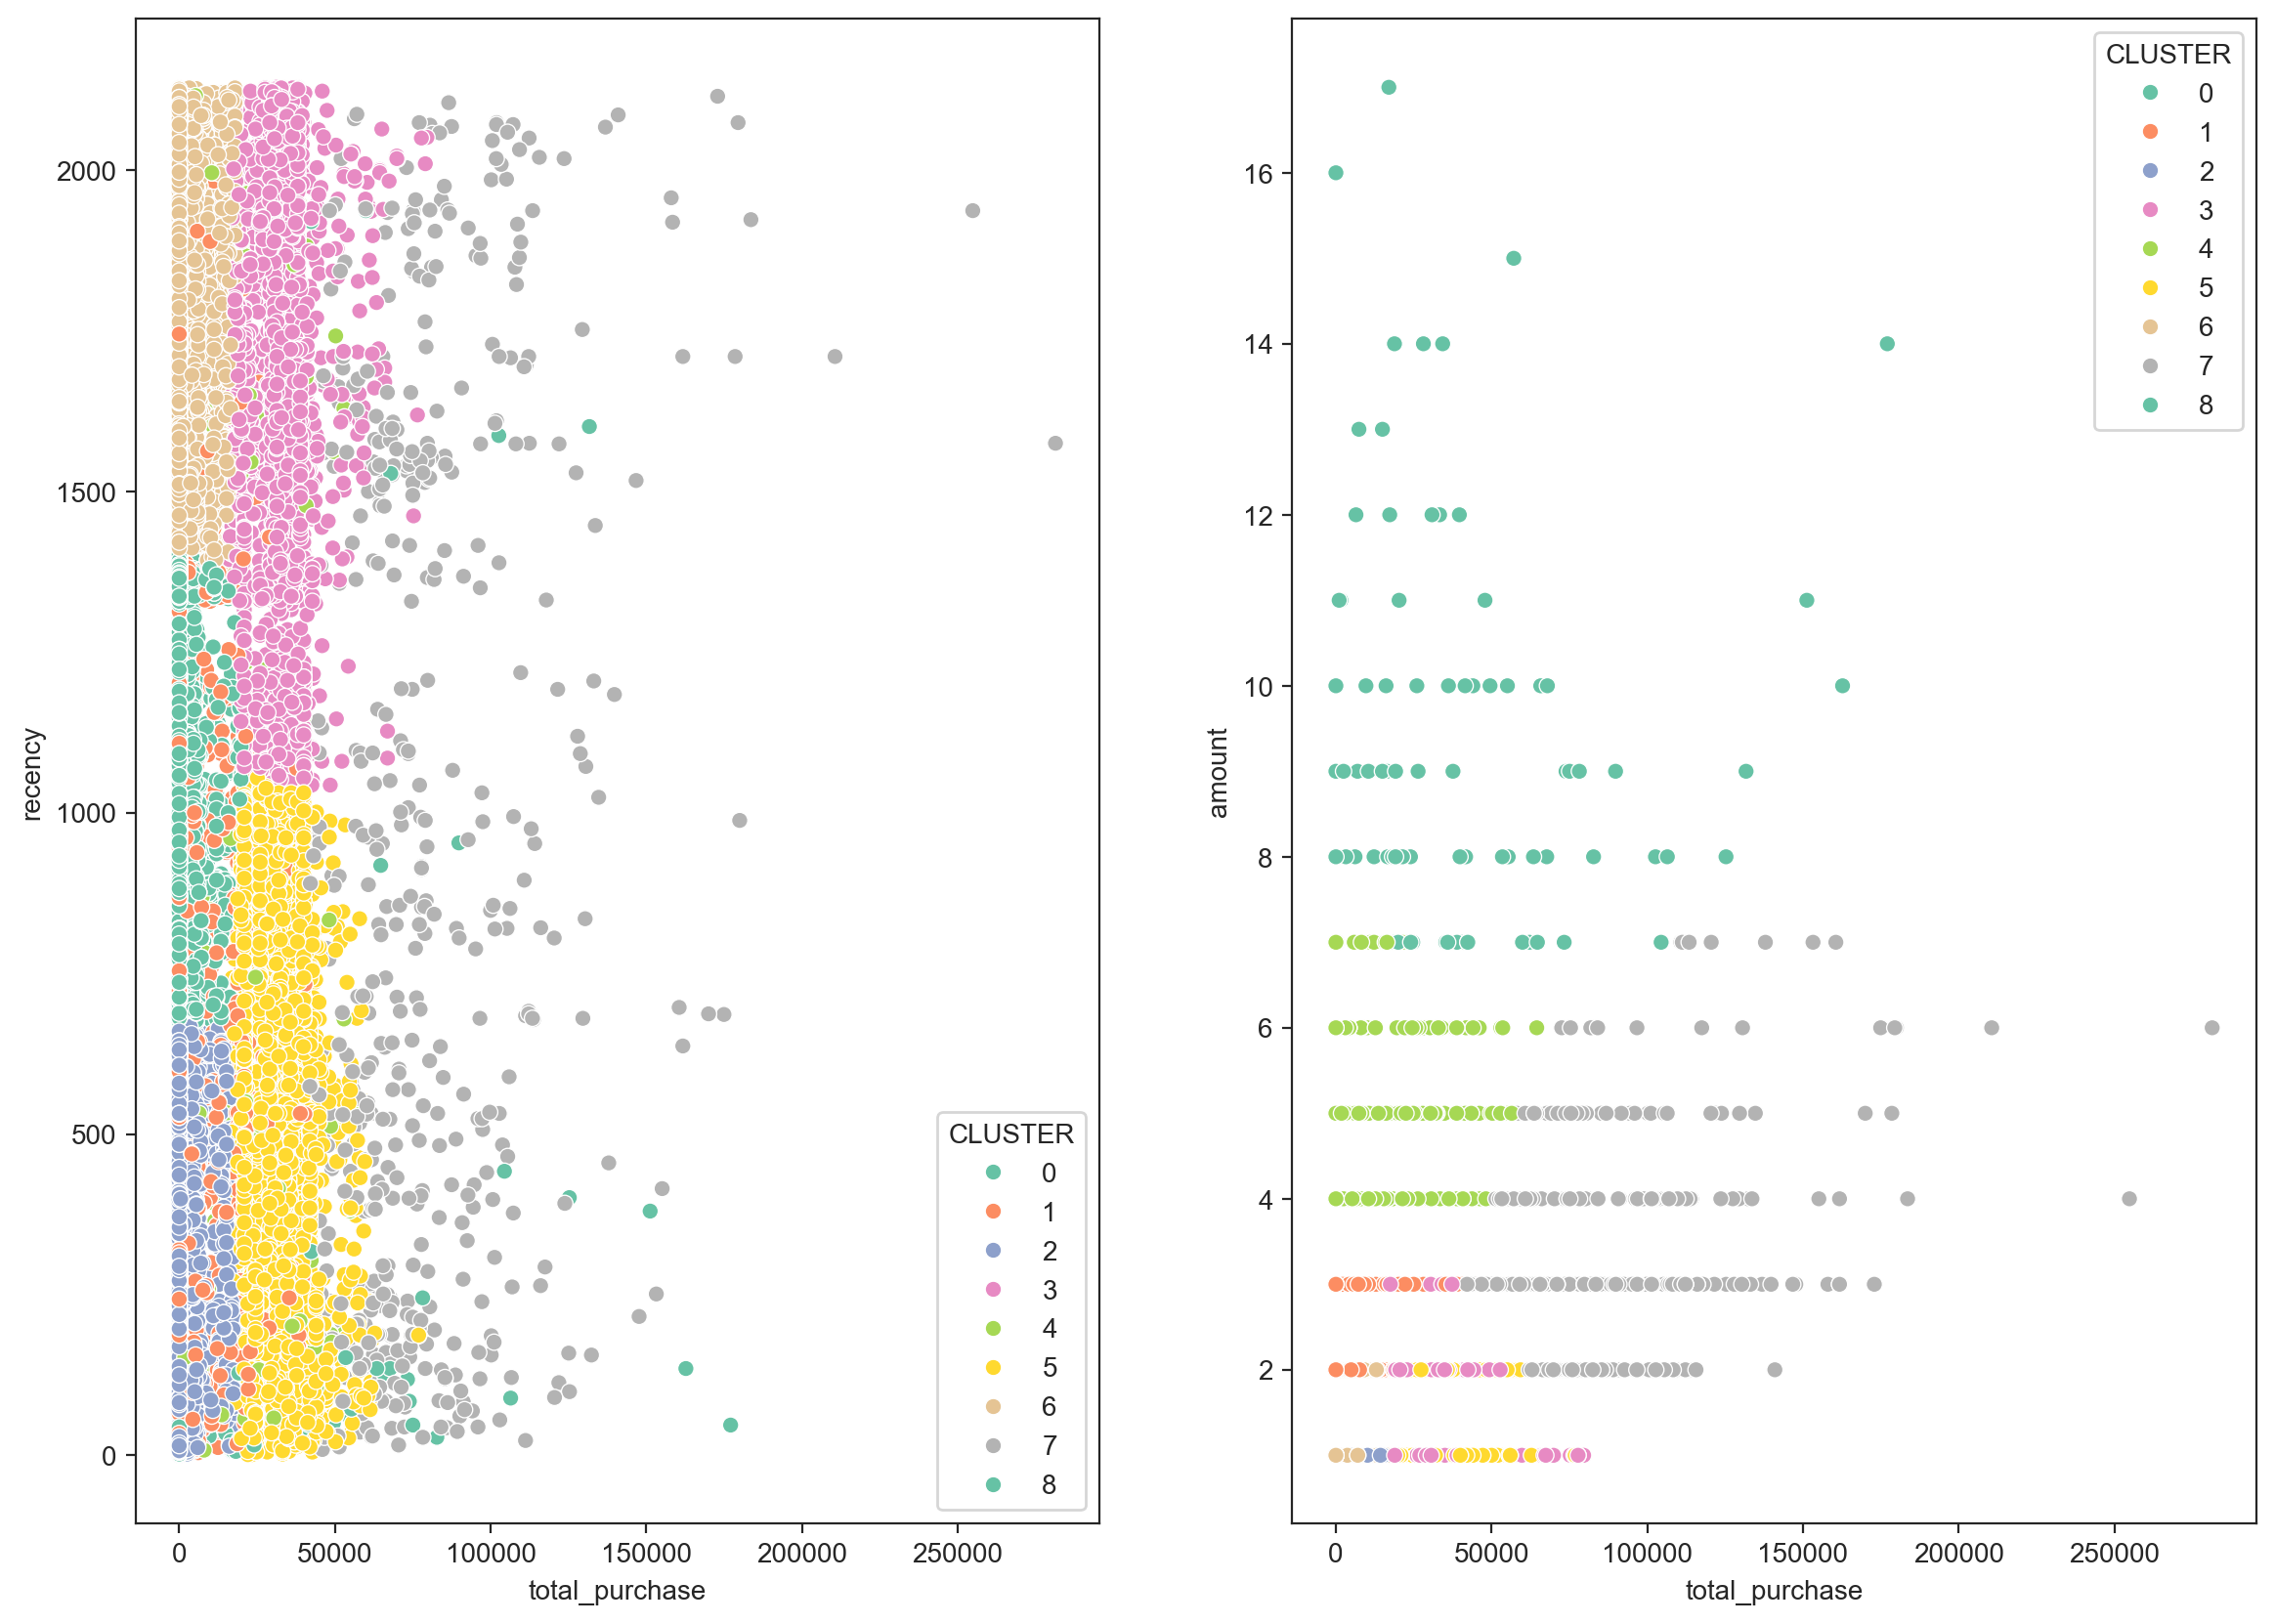

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(14, 10))

sns.scatterplot(x = data_tmp['total_purchase'], y = data_tmp['recency'], hue=data_tmp['CLUSTER'],palette='Set2', ax = axes[0])

sns.scatterplot(x = data_tmp['total_purchase'], y = data_tmp['amount'], hue=data_tmp['CLUSTER'], palette='Set2', ax = axes[1])

<Figure size 640x480 with 0 Axes>

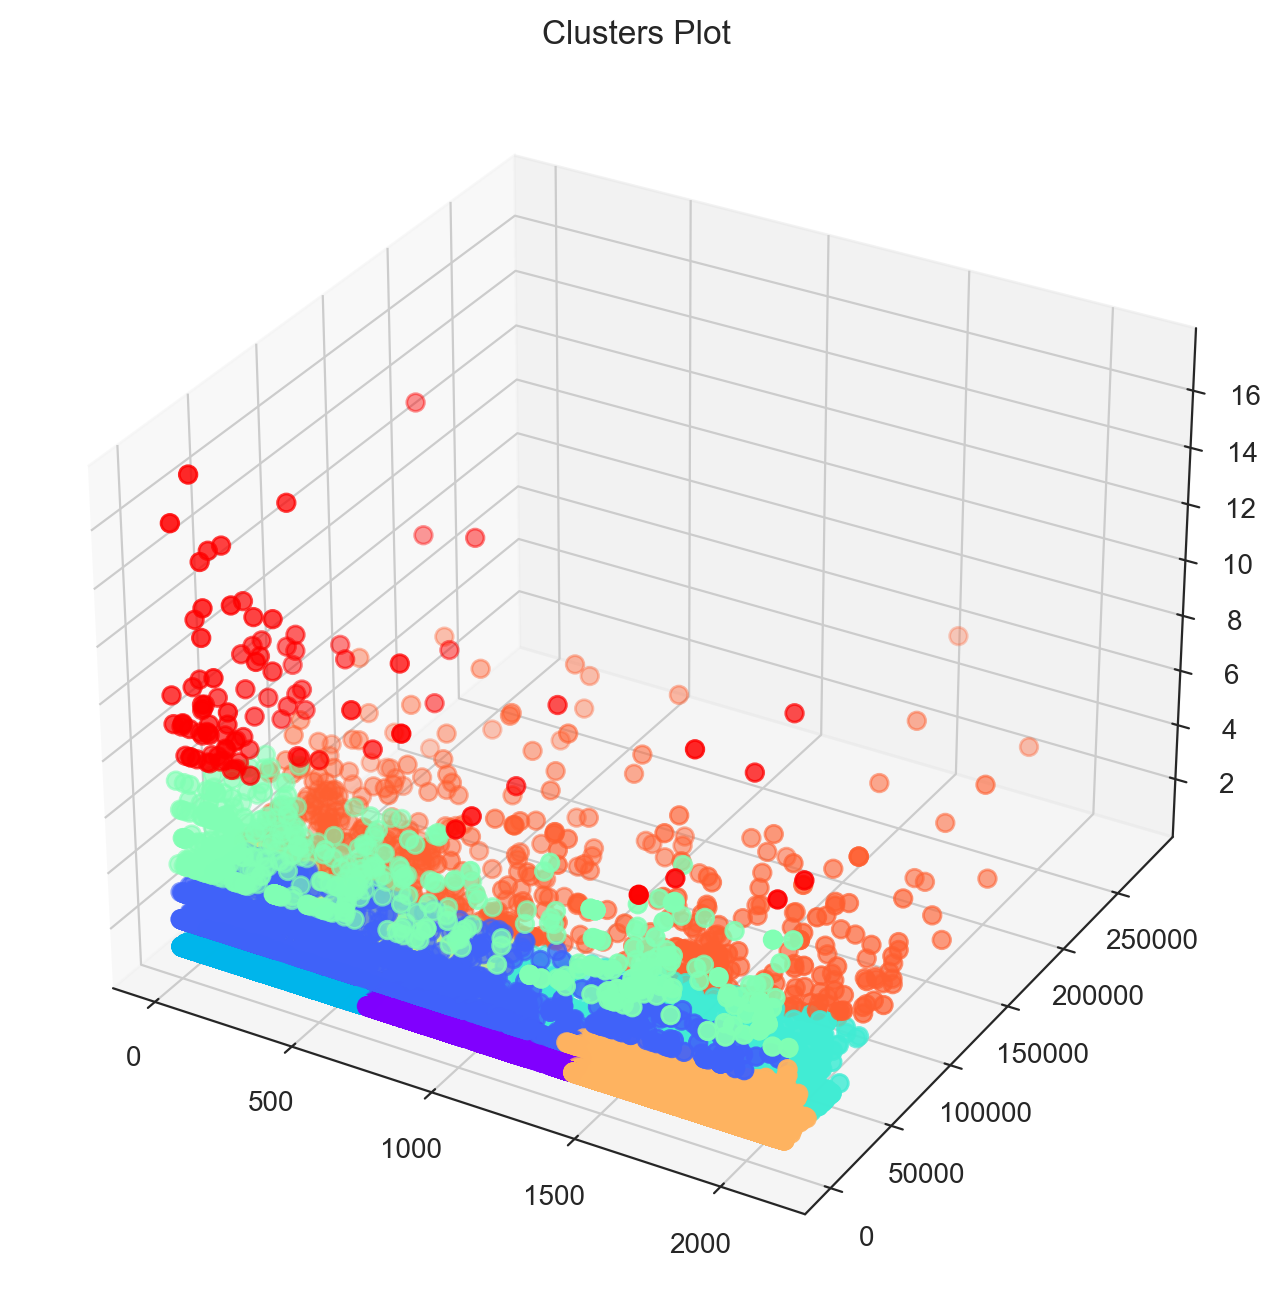

In [56]:
fig = plt.figure()

x, y, z = data_tmp['recency'], data_tmp['total_purchase'], data_tmp['amount']

plt.figure(figsize=(10,8))

ax = plt.subplot(111, projection='3d', label='bla')
ax.scatter(x, y, z, s=40, c=data_tmp['CLUSTER'], marker='o', cmap='rainbow')
ax.set_title('Clusters Plot')

plt.show()

## 1.2. Hierarquical

First, I will compute the entire dendogram using the `ward` linkage.

In [58]:
Z = linkage(data_tmp_scaled, 'ward', )

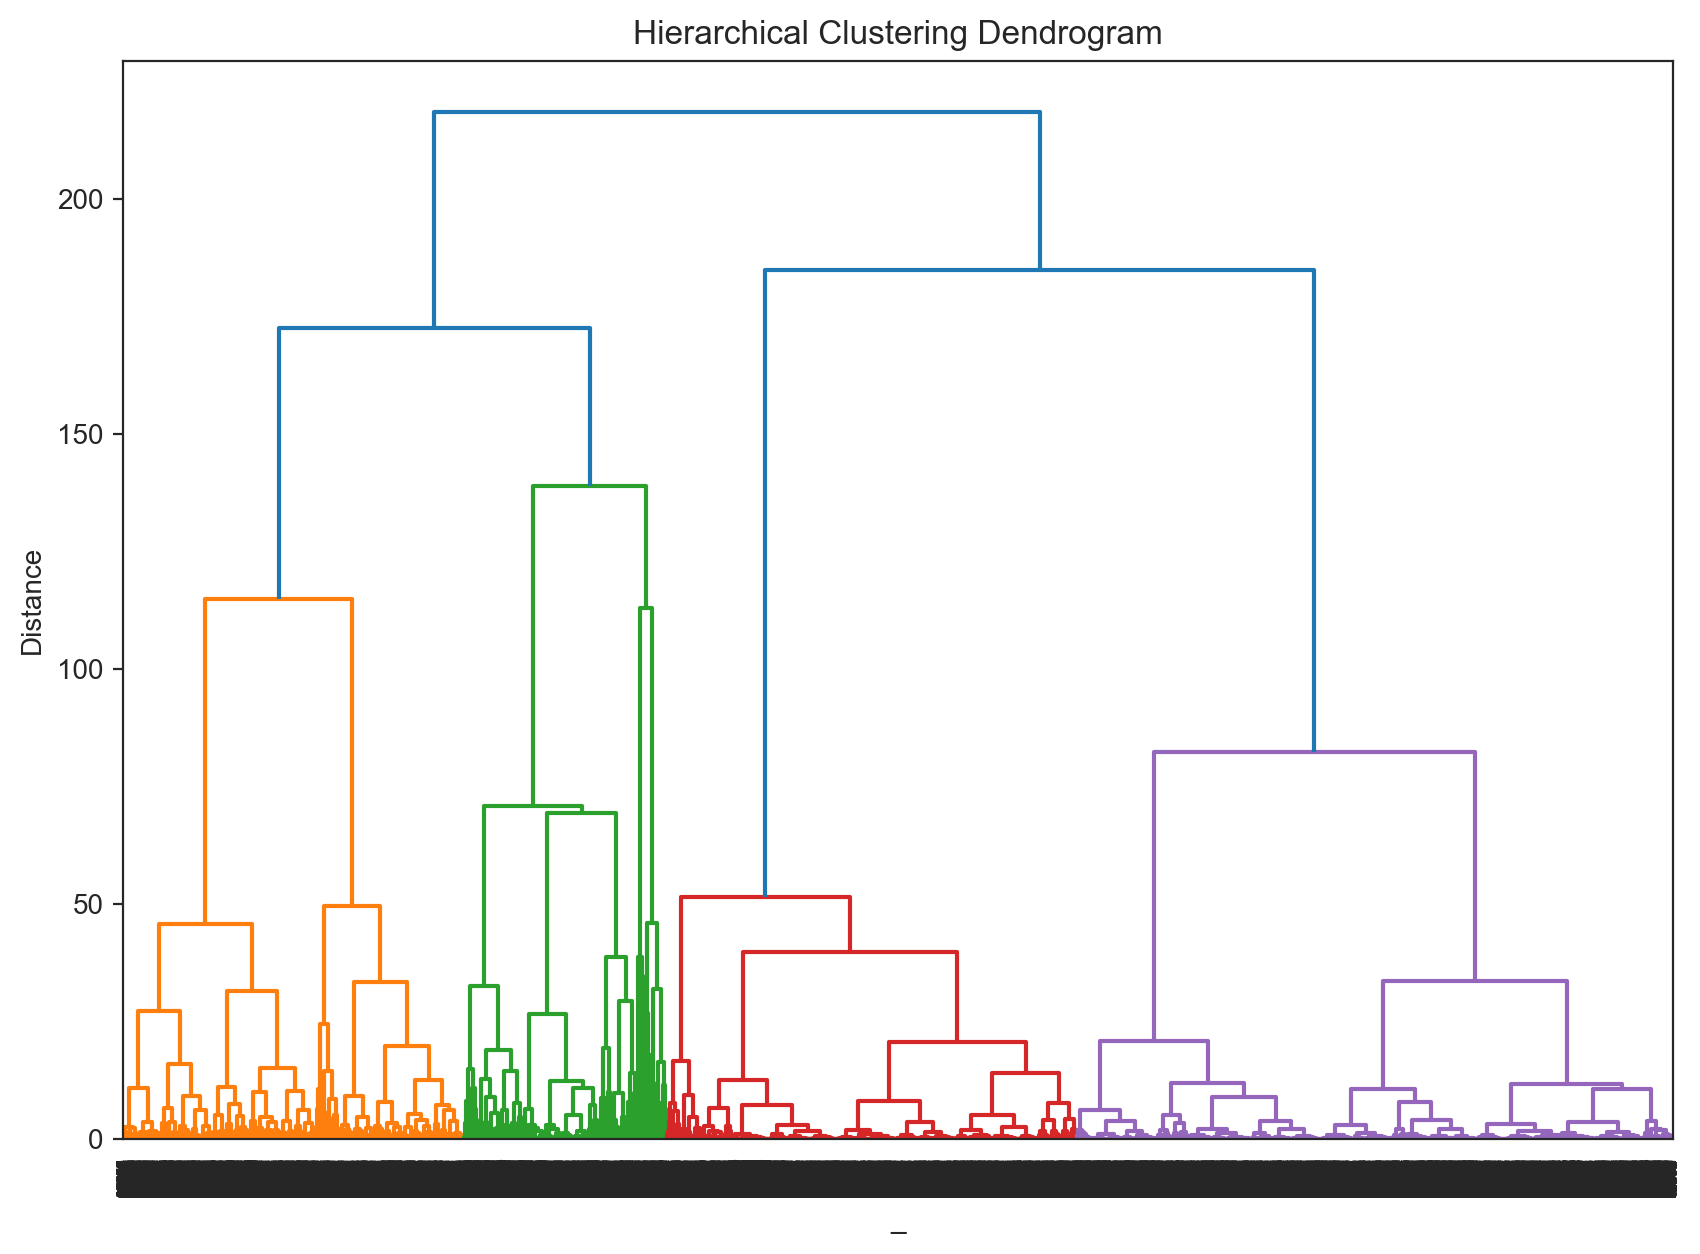

In [59]:
# Create a dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('_')
plt.ylabel('Distance')
plt.show()


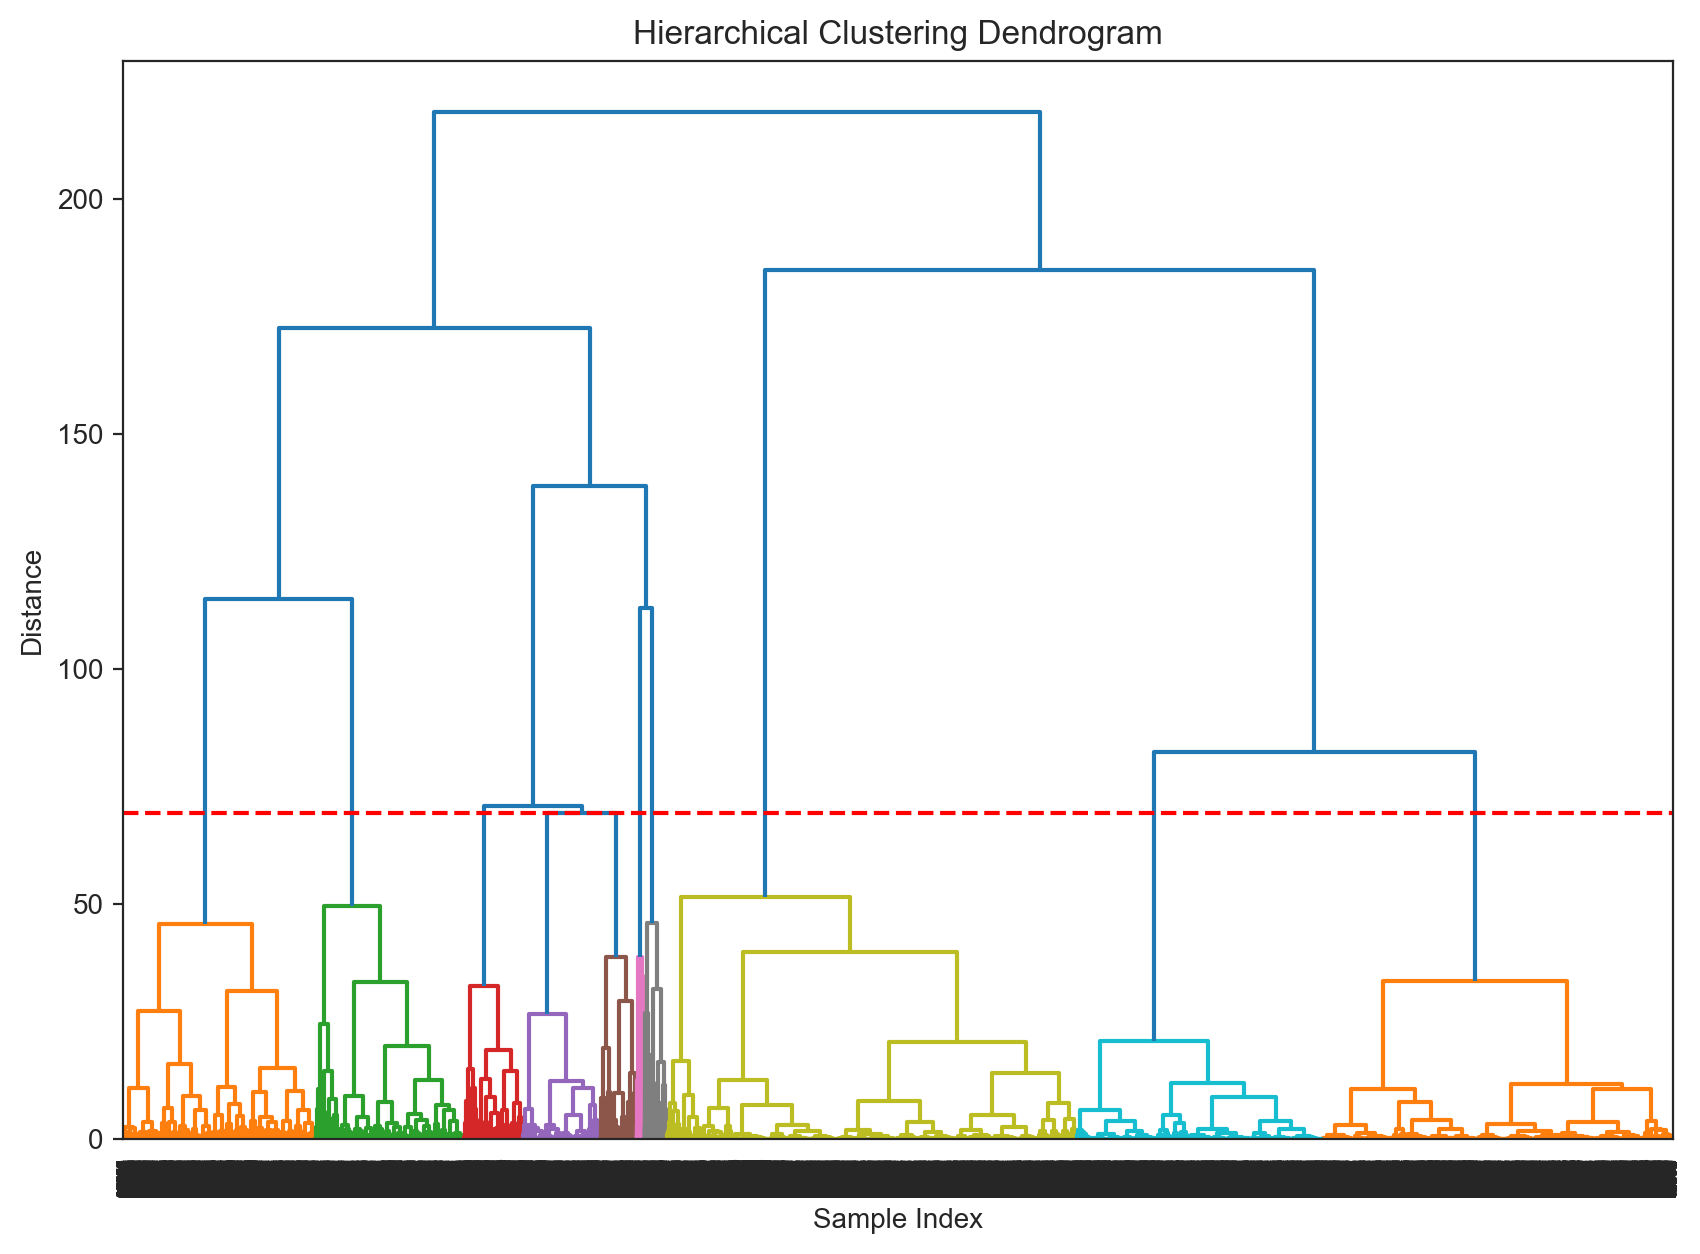

In [65]:
# Set the color threshold to select 9 clusters
max_d = Z[-9, 2]

# Create a dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, color_threshold=max_d)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.axhline(y=max_d, color='r', linestyle='--')
plt.show()

In [68]:
max_d = Z[-9, 2]

# Form flat clusters
labels = fcluster(Z, max_d, criterion='distance')

In [69]:
data_tmp['CLUSTER_HIER'] = labels

In [70]:
data_tmp

,id_client,amount,total_purchase,recency,CLUSTER,CLUSTER_HIER
0,00006A95660,1,0.000,1339,0,7
1,000226822A0,1,0.000,1021,0,8
2,00026208A2A,1,39980.000,923,5,1
3,00032b5965b,1,4122.500,246,2,9
4,00035Ab4AA0,1,0.000,1329,0,7
...,...,...,...,...,...,...
35295,bbb95b9654,1,30620.000,2049,3,2
35296,bbbb0420Ab2,1,0.000,579,2,9
35297,bbbb3349649,1,0.000,1890,6,7
35298,bbbb422A9b2,1,18900.000,1680,3,2


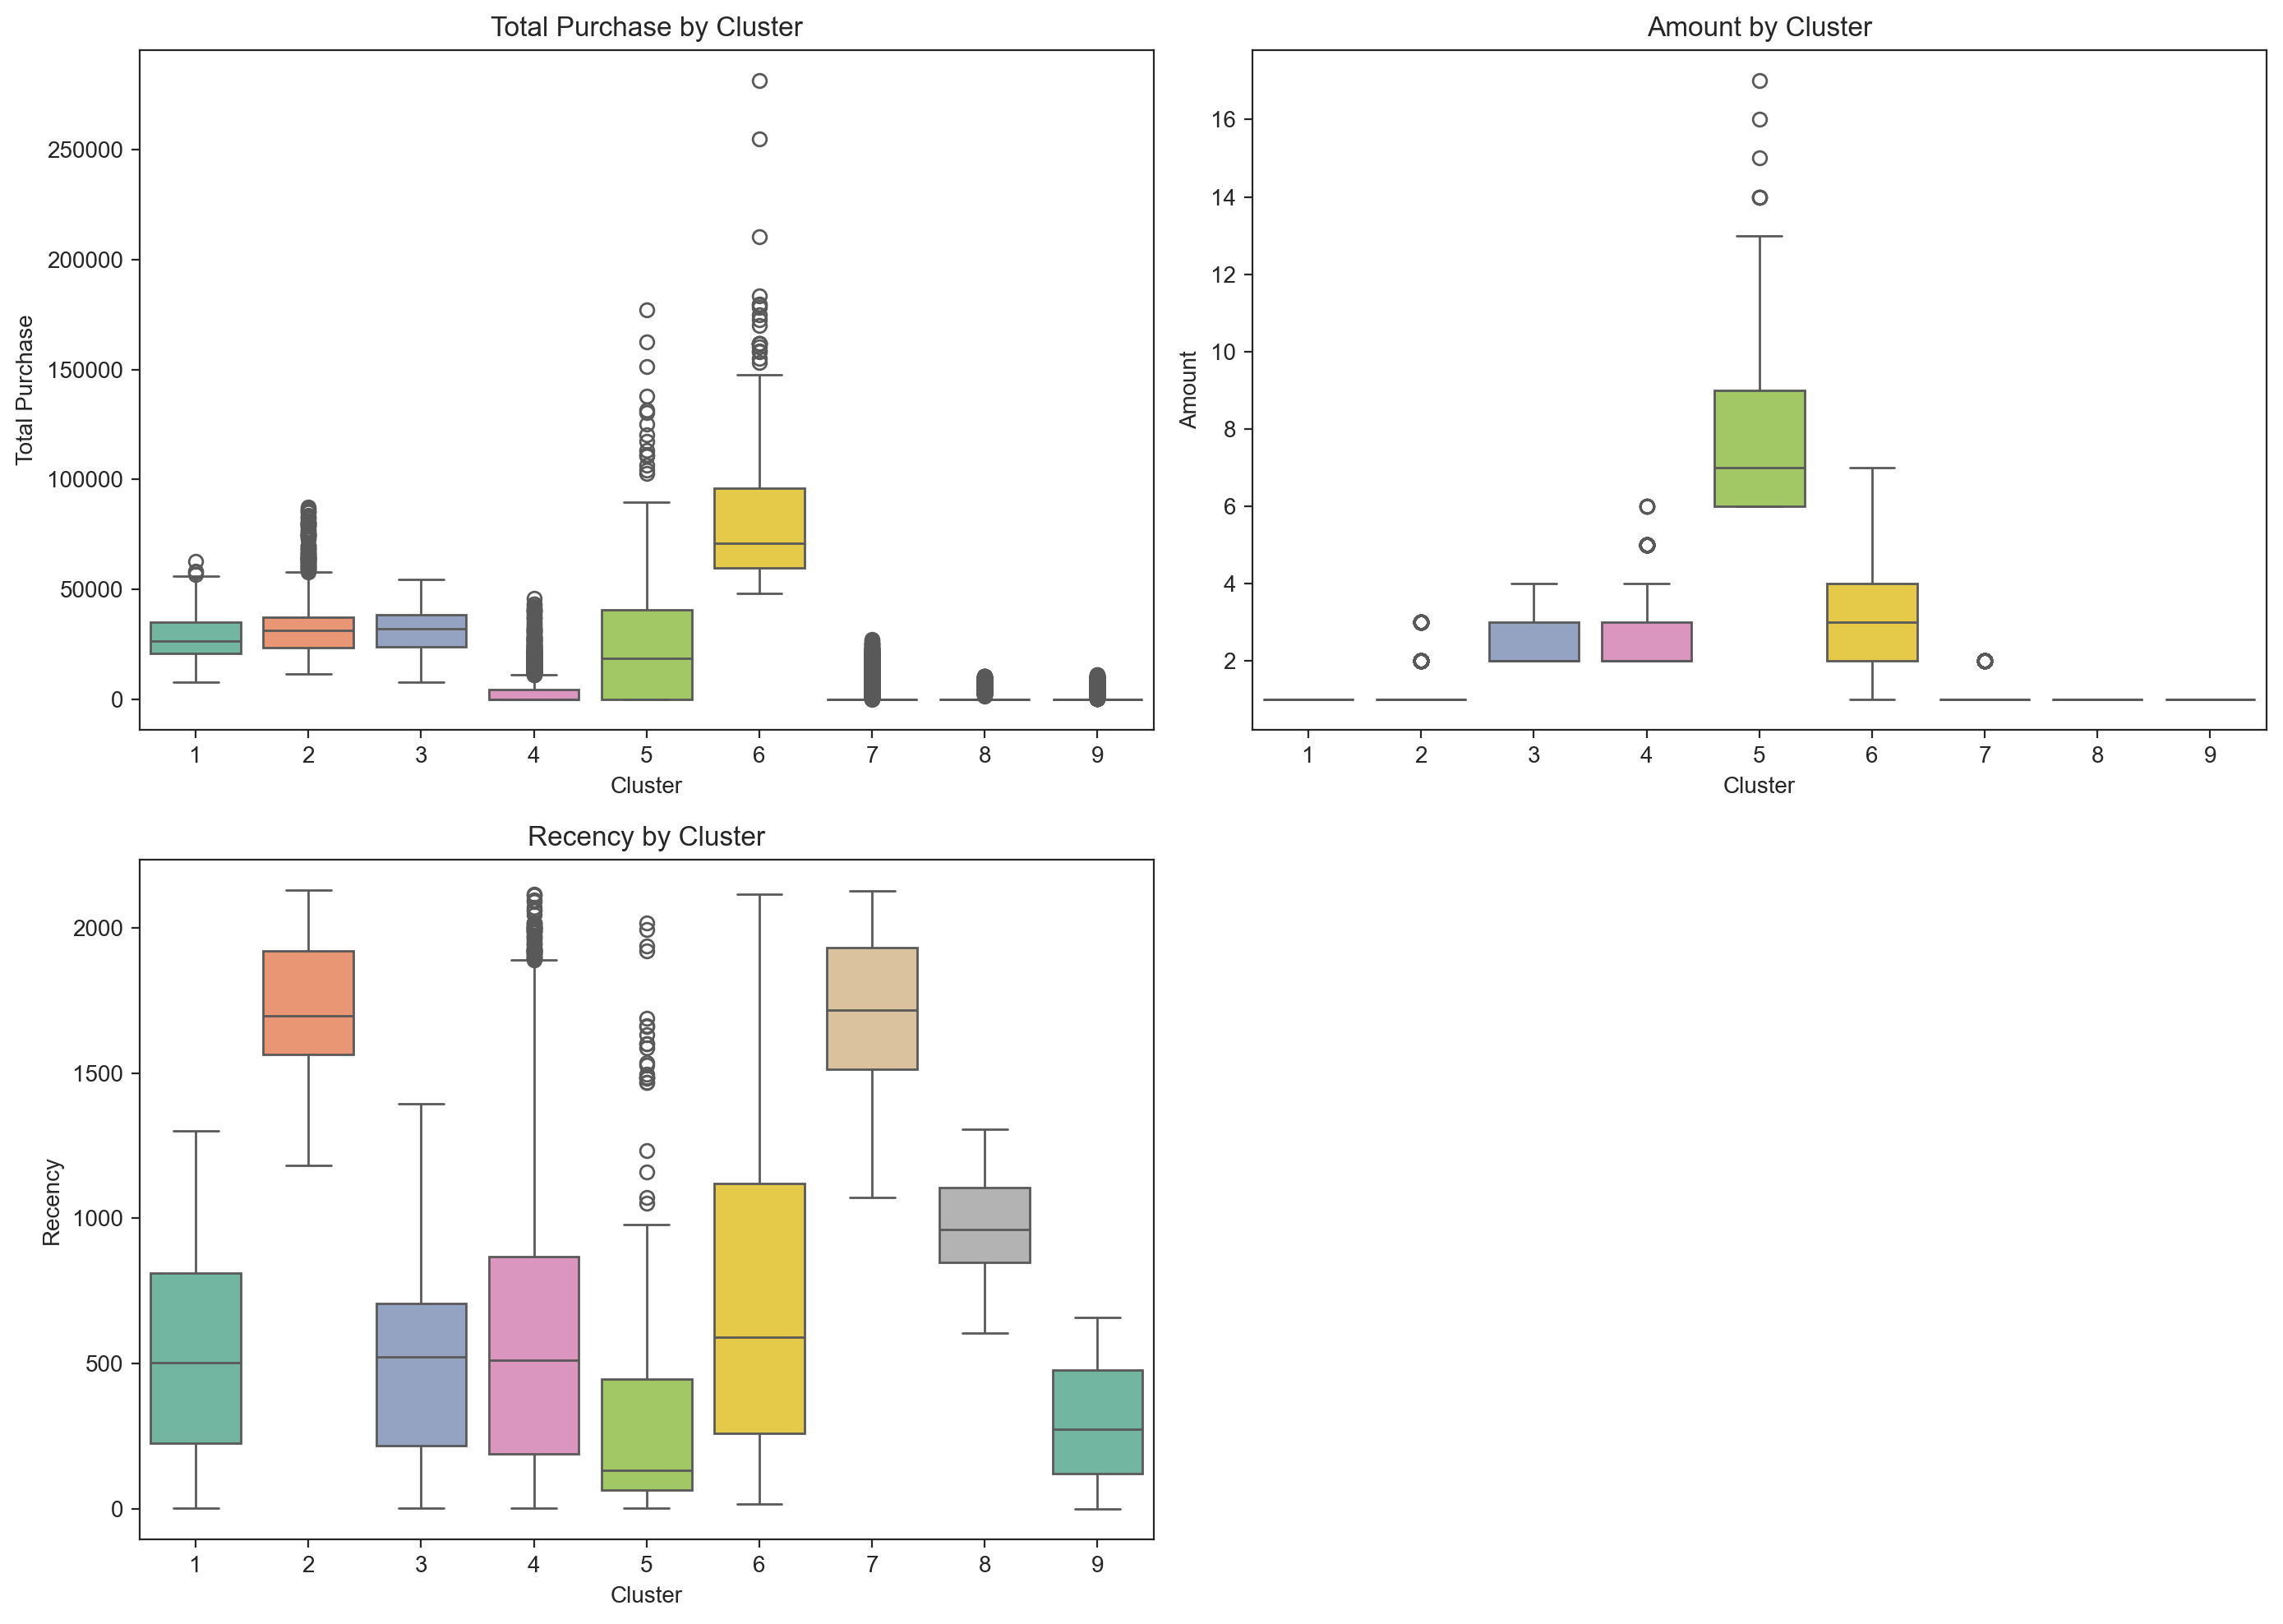

In [71]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(y = 'total_purchase', x = 'CLUSTER_HIER', data = data_tmp,  ax=axes[0, 0], palette='Set2')
axes[0, 0].set_title('Total Purchase by Cluster')
axes[0, 0].set_ylabel('Total Purchase')
axes[0, 0].set_xlabel('Cluster')

sns.boxplot(y = 'amount', x = 'CLUSTER_HIER', data = data_tmp,  ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('Amount by Cluster')
axes[0, 1].set_ylabel('Amount')
axes[0, 1].set_xlabel('Cluster')

sns.boxplot(y = 'recency', x = 'CLUSTER_HIER', data = data_tmp, ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('Recency by Cluster')
axes[1, 0].set_ylabel('Recency')
axes[1, 0].set_xlabel('Cluster')

axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

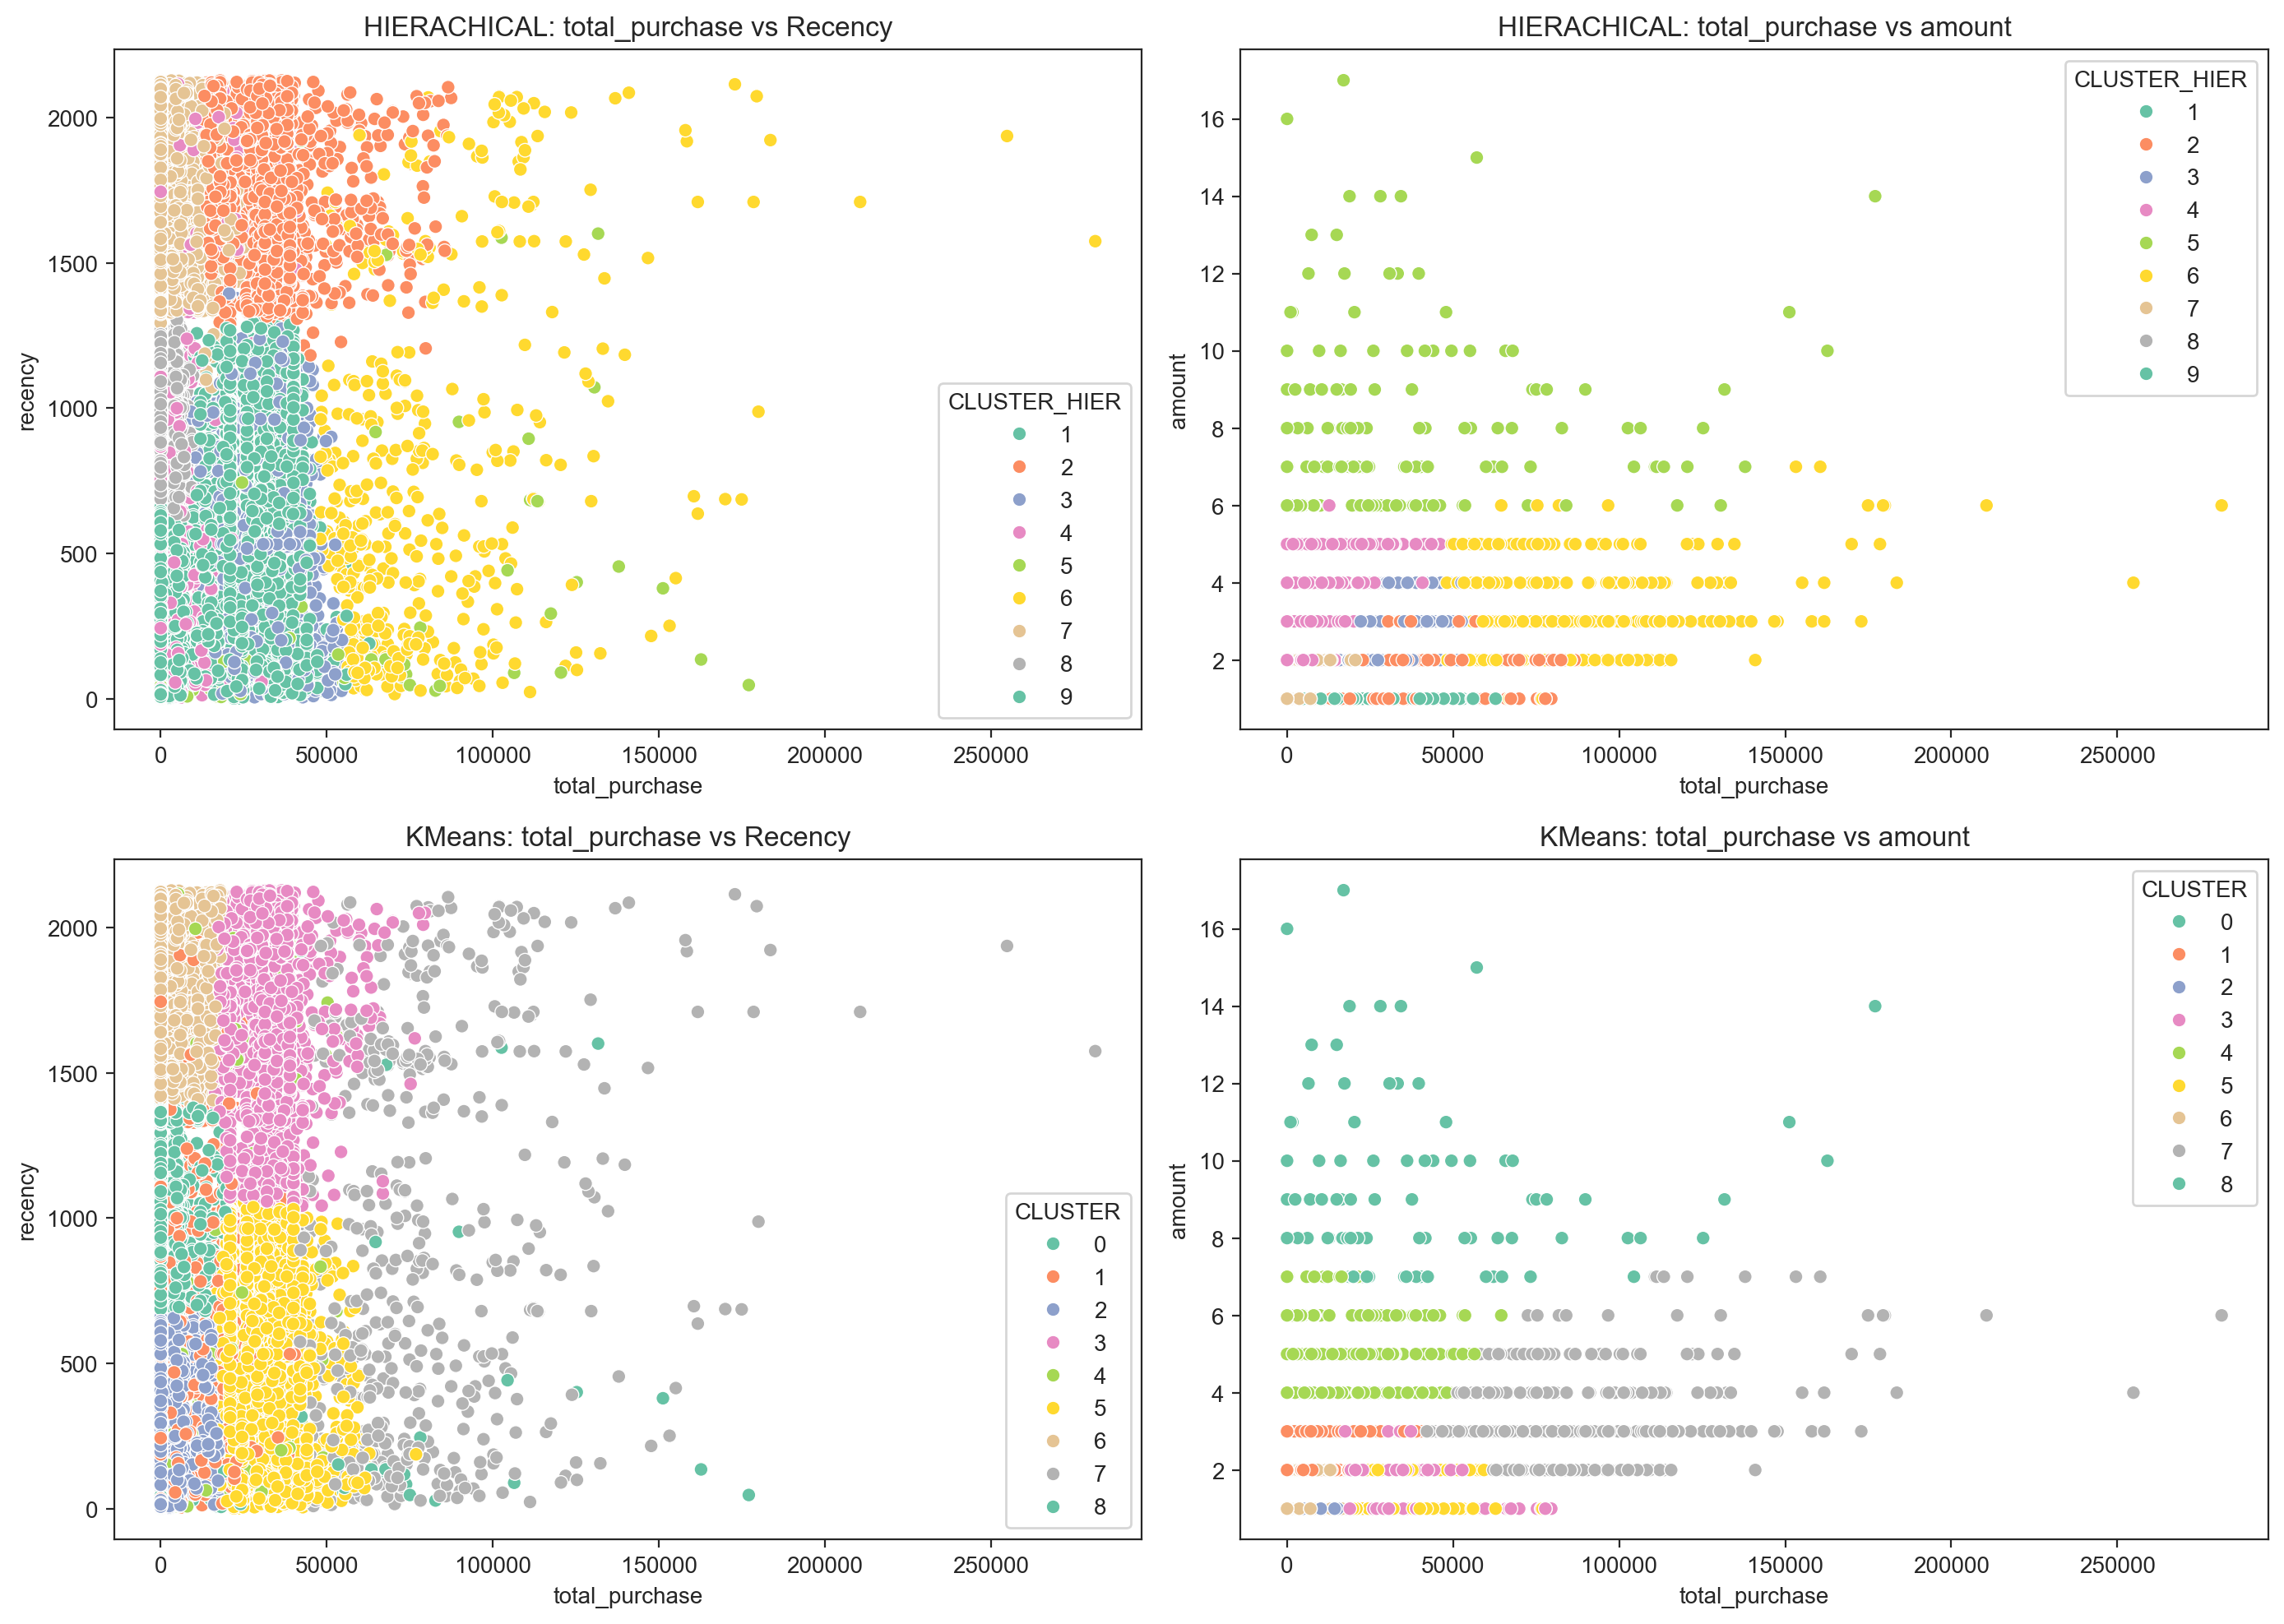

In [77]:
# Comparing the KMeans and the Hierarchical

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.scatterplot(x = data_tmp['total_purchase'], y = data_tmp['recency'], hue=data_tmp['CLUSTER_HIER'],palette='Set2', ax = axes[0,0])
axes[0,0].set_title('HIERACHICAL: total_purchase vs Recency')

sns.scatterplot(x = data_tmp['total_purchase'], y = data_tmp['amount'], hue=data_tmp['CLUSTER_HIER'], palette='Set2', ax = axes[0,1])
axes[0,1].set_title('HIERACHICAL: total_purchase vs amount')

sns.scatterplot(x = data_tmp['total_purchase'], y = data_tmp['recency'], hue=data_tmp['CLUSTER'],palette='Set2', ax = axes[1,0])
axes[1,0].set_title('KMeans: total_purchase vs Recency')

sns.scatterplot(x = data_tmp['total_purchase'], y = data_tmp['amount'], hue=data_tmp['CLUSTER'], palette='Set2', ax = axes[1,1])
axes[1,1].set_title('KMeans: total_purchase vs amount')

plt.tight_layout()
plt.show()

- Hierarchical Clustering
    - Total Purchase vs Recency (Top Left)
The clusters seem well-defined with distinct boundaries.
There are clear segments of users based on their purchasing behavior and recency.
    - Total Purchase vs Amount (Top Right)
The clusters are more spread out and less distinct.
There is some overlap in the clusters, but overall, the distribution shows some clear patterns.

- K-Means Clustering
    - Total Purchase vs Recency (Bottom Left)
The clusters are more evenly distributed.
There is a larger presence of outliers (grey points) that are not included in any cluster, indicating that K-means might have struggled with some data points.
    - Total Purchase vs Amount (Bottom Right)
Similar to the hierarchical clustering, the clusters show some spread but are more uniform.
The presence of grey points indicates outliers not assigned to clusters, which might be a result of the K-means initialization or the inherent nature of the data.

Considering the size of the dataset and the computational resources, we decided to use the KMeans clusters to the next steps.

# 2. Profiles

In [88]:
# Function to calculate main statistics
def calculate_cluster_statistics(df, cluster_column):
    stats = df.groupby(cluster_column).agg(
        amount_mean=('amount', 'mean'),
        total_purchase_mean=('total_purchase', 'mean'),
        recency_mean=('recency', 'mean'),
        amount_median=('amount', 'median'),
        total_purchase_median=('total_purchase', 'median'),
        recency_median=('recency', 'median'),
        amount_std=('amount', 'std'),
        total_purchase_std=('total_purchase', 'std'),
        recency_std=('recency', 'std')
    )
    return stats

# Calculate statistics for each 'CLUSTER'
cluster_stats = pd.DataFrame(calculate_cluster_statistics(data_tmp, 'CLUSTER'))
print("Cluster Statistics:")
display(cluster_stats)

Cluster Statistics:


,amount_mean,total_purchase_mean,recency_mean,amount_median,total_purchase_median,recency_median,amount_std,total_purchase_std,recency_std
CLUSTER,,,,,,,,,
0,1.000,1523.598,1026.208,1.000,0.000,986.000,0.000,3590.416,195.465
1,2.246,5587.180,564.643,2.000,0.000,520.000,0.431,9077.534,434.854
2,1.000,1644.781,309.941,1.000,0.000,277.500,0.000,3834.987,197.492
3,1.224,32311.703,1640.016,1.000,32500.000,1637.000,0.459,8028.101,284.327
4,4.633,14707.366,667.840,4.000,9820.000,473.500,0.889,15536.113,622.147
5,1.200,31605.752,456.545,1.000,31409.200,465.000,0.406,8397.181,283.049
6,1.071,2144.894,1772.276,1.000,0.000,1749.000,0.259,4348.897,211.300
7,3.165,79719.523,907.861,3.000,73220.000,788.000,1.098,30182.582,645.232
8,9.220,35493.509,271.800,9.000,23370.000,115.000,2.144,37712.464,444.563


# 2. Profiles and Marketing Strategy


- **Cluster 0: Infrequent Low Spenders**
    - Name: Emma
    - Profile: Emma is a busy professional who rarely finds time for online learning. When she makes a purchase, it's usually a low-cost course to quickly brush up on a specific skill. She hasn't made any recent purchases, indicating she might have found other priorities.
    - Total Purchase: Low | Recency: High | Amount: Low

**Marketing Strategy:** Offer special discounts and promotions to encourage more frequent purchases.


- **Cluster 1: New Engagers**
    - Name: James
    - Profile: James recently discovered your plataform and is exploring various free content and intoductory offers. He;s excited about learning but hasn’t commited to high-value purchases yet. He shows potential for becoming a loyal customer if nurtured properly with engaging content and special offers.
    - Total Purchase: Low | Recency: Low | Amount: Low

**Marketing Strategy:** Focus on engagement strategies like onboarding emails and introductory offers.


- **Cluster 2: Budget Learners**
    - Name: Sarah
    - Profile: Sarah is a buget-conscious learner who looks for affordable ways to improve her skills. She makes moderate purchases but is consistent is seeking value for her money. She often looks for discounts and bundles to make the most out of her limited budget.
    - She has enrolled in several mid-range courses and occasionally participates in webinars and free training sessions.
    - Total Purchase: Moderate | Recency: Moderate | Amount: Low
  
**Marketing Strategy:** Promote budget-friendly courses and training packages.

- **Cluster 3: Frequent Low Spenders**
    - Name: David
    - Profile: David loves learning new things bur preffers smaller, more frequent investiments in his education. He often purchases short, low-cost courses. Regurlarly, he checks for new content and make frequent small purchases. 
    - Total Purchase: Low | Recency: Low to Moderate | Amount: Low
  
**Marketing Strategy:** Bundle low-cost products and promote subscription-based models.

- **Cluster 4: Engaged Budget Spenders**
  - Name: Linda
  - Profile: Linda is a dedicated learner who engages with the platform regularly. She spends a moderate amount on courses and training. Linda has been with your platform for a while and has steadily invested in varios courses.
  - Total Purchase: Moderate | Recency: Moderate | Amount: Moderate

**Marketing Strategy:** Offer loyalty rewards and personalized course recommendations.

- **Cluster 5: Occasional High Spenders**
  - Name: Robert
  - Profile: Robert is selective about his learning investiments, prefering to spend on high-quality, high-value courses occasionally. He tipically makes a few big purchases a year. He values quality over quantity and looks for courses that offer substantial returns on his investiment.
  - Total Purchase: Moderate | Recency: High | Amount: High
  
**Marketing Strategy:** Highlight premium content and high-value training programs.

- **Cluster 6: High Spenders with Low Engagement**
  - Name: Jessica
  - Profile: Jessica has spent a signiificant amount on our platform but doesn`t engage frequently. She makes large purchases.
  - Total Purchase: High | Recency: High | Amount: High
  
**Marketing Strategy: Provide exclusive content and VIP access to keep them engaged.**

- **Cluster 7: High Value, High Engagement**
  - Name: Michael
  - Profile: Michael is one of your top customers, consistently spending a lot and engaging frequently. Regulaly, he purchases high-values courses.
  - Total Purchase: High | Recency: Low to Moderate | Amount: High
  
**Marketing Strategy: Focus on retention with personalized communication, exclusive offers, and premium services.**

- **Cluster 8: Elite Learners**
  - Name: Alice
  - Profile: Alice is an elite learner who is highly committed to her personal and professional development. She makes substantial investments in her education and engages with almost all the content offered.
  - Total Purchase: Very High | Recency: Low to Moderate | Amount: Very High
  
**Marketing Strategy: Maintain close relationships through personal touchpoints and offer exclusive content and first access to new products.**

- For the groups 3 and 6, that have a higher recency and lower amount of purchase, a strategy could be to remove them from the client data and focus on the others clients who have "recent" memories of the products.

# 3. Further Steps

- Perform a deeper analysis of each cluster to understand the underlying reasons for their behavior. This could involve looking into additional features or segmenting further within the existing clusters.

- Develop tailored marketing strategies for each cluster. For example, groups with high recency but low purchase amounts might benefit from promotional offers or targeted advertising to convert their recent interest into higher spending.

- Focus on retention strategies for high-value clusters with lower recency. Implement loyalty programs, personalized communication, and special offers to re-engage these customers.

- Create new models considering more features such as customer demographics, browsing behavior, and social media interactions. This can provide more dimensions for clustering and reveal more nuanced customer segments.

- Conduct A/B tests in each group considering different kinds of products. This will help in understanding what types of products and offers are most effective for each cluster.